In [112]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import lina
import lina.psds as psds

from magpyx.utils import ImageStream

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

wavelength = 633e-9


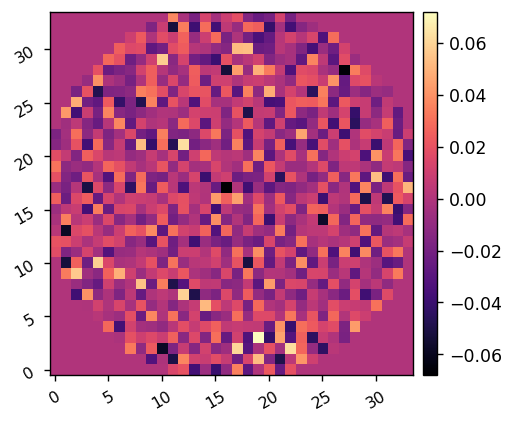

In [115]:
dhc_stream = ImageStream('dm00disp05')
imshow1(dhc_stream.grab_latest())

In [53]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', locam_channel='nsvcam', dm_channel='dm00disp01')

# Aquire LLOWFSC image

In [4]:
reload(scoobi)
scoobi.move_block_in(client0)

In [6]:
reload(scoobi)
scoobi.move_block_out(client0)

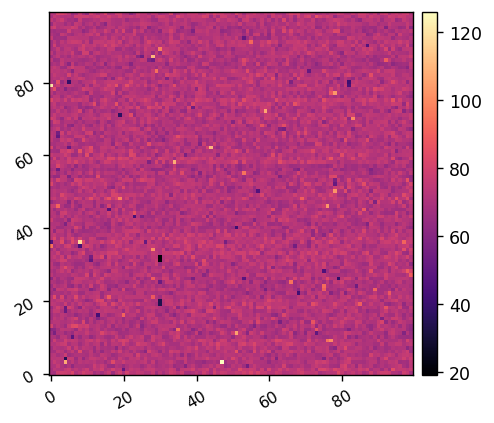

In [54]:
# I.Nframes = 100
# I.subtract_dark_locam = False
# I.return_ni_locam = False
# dark_frame = I.snap_locam()
I.df_locam = copy.copy(dark_frame)
imshow1(dark_frame)

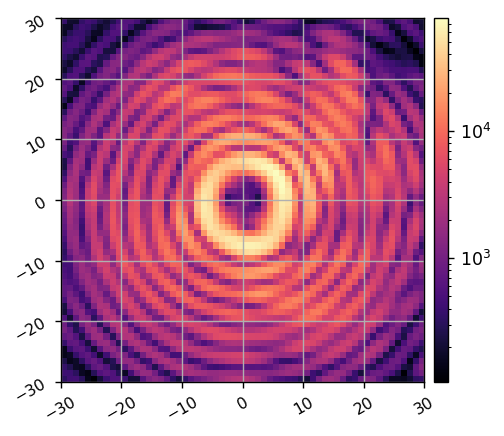

In [89]:
I.x_shift_locam = 0
I.y_shift_locam = 8
I.nlocam = 60
I.NLOCAM = 100

I.ref_locam_params = {
    'atten':0, 
    'texp':0.0001
}

I.att = 0
I.texp_locam = 0.0001
I.gain_locam = 120
I.return_ni_locam = True
I.subtract_dark_locam = False

ref_im = I.snap_locam()
imshow1(ref_im, grid=True, pxscl=1, lognorm=True)

# Perform LLOWFSC calibration

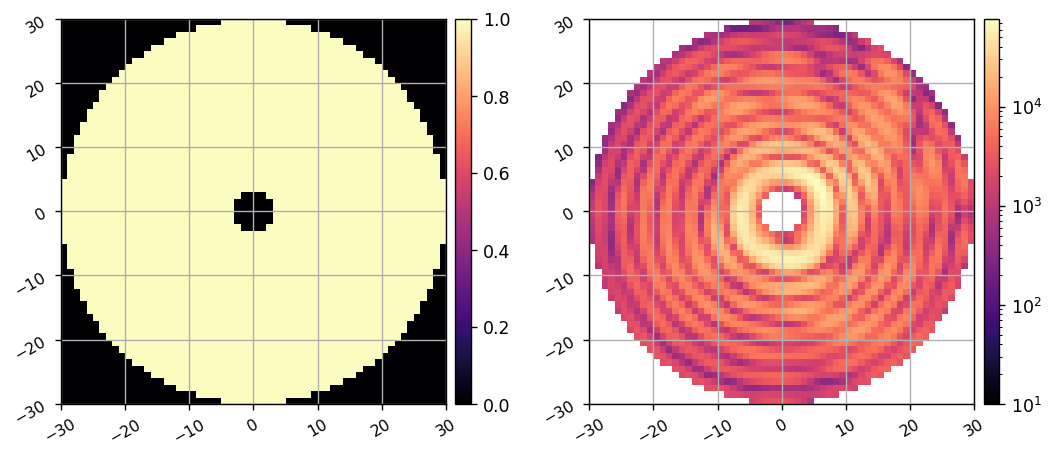

In [90]:
irad = 3
orad = 30
control_mask = ensure_np_array(lina.utils.create_annular_focal_plane_mask(I.nlocam, 1, irad, orad, edge=None, ))
# control_mask = xp.ones((M.nlocam, M.nlocam)).astype(bool)
imshow2(control_mask, ref_im * control_mask, grid=True, pxscl=1, lognorm2=True, vmin2=1e1)

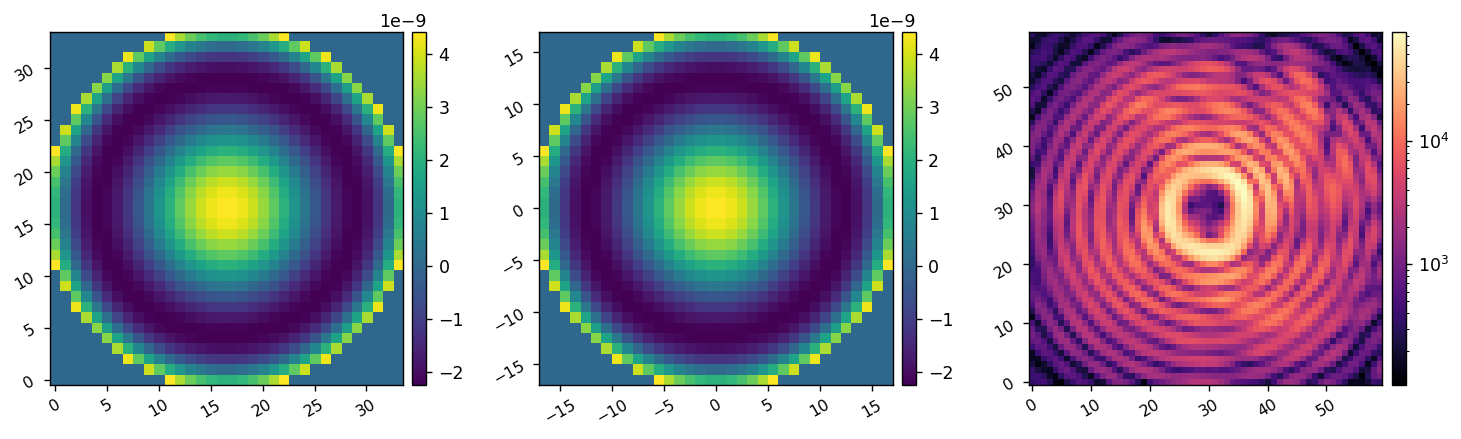

In [91]:
reload(lina.utils)
Nz_modes = 10
I.NLOCAM = 1
I.zero_dm()
dm_modes = ensure_np_array(lina.utils.create_zernike_modes(I.dm_mask, nmodes=Nz_modes, remove_modes=1))
zer_modal_matrix = dm_modes.reshape(Nz_modes, -1)

i = -1
amp = 2e-9
I.add_dm(amp*dm_modes[i])
locam_im = I.snap_locam()
imshow3(amp*dm_modes[i], I.get_dm(), locam_im, cmap1='viridis', cmap2='viridis', pxscl2=1, lognorm3=True)
I.zero_dm()

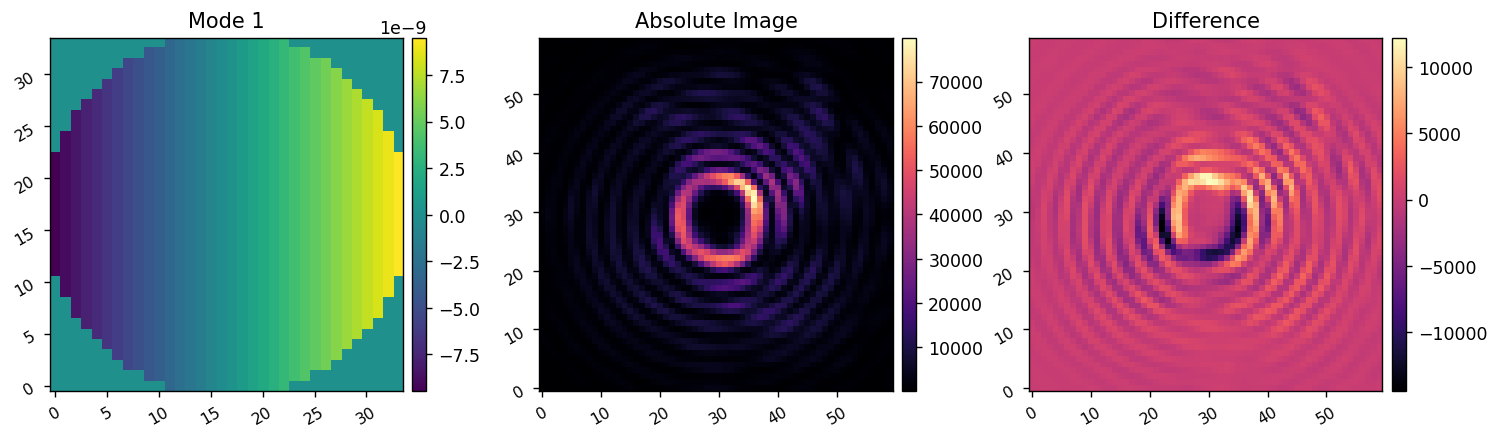

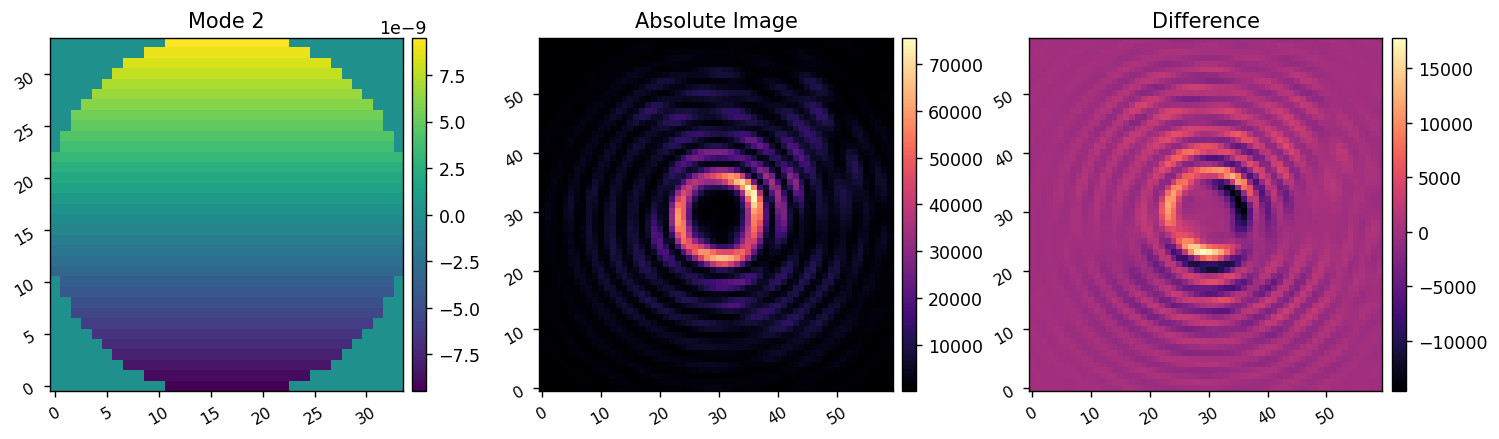

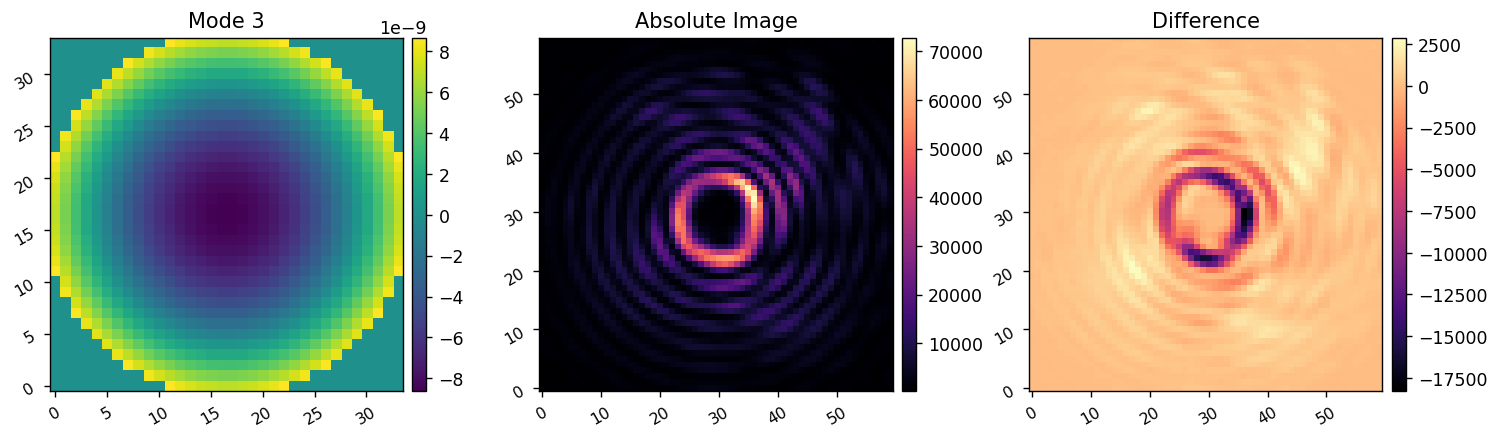

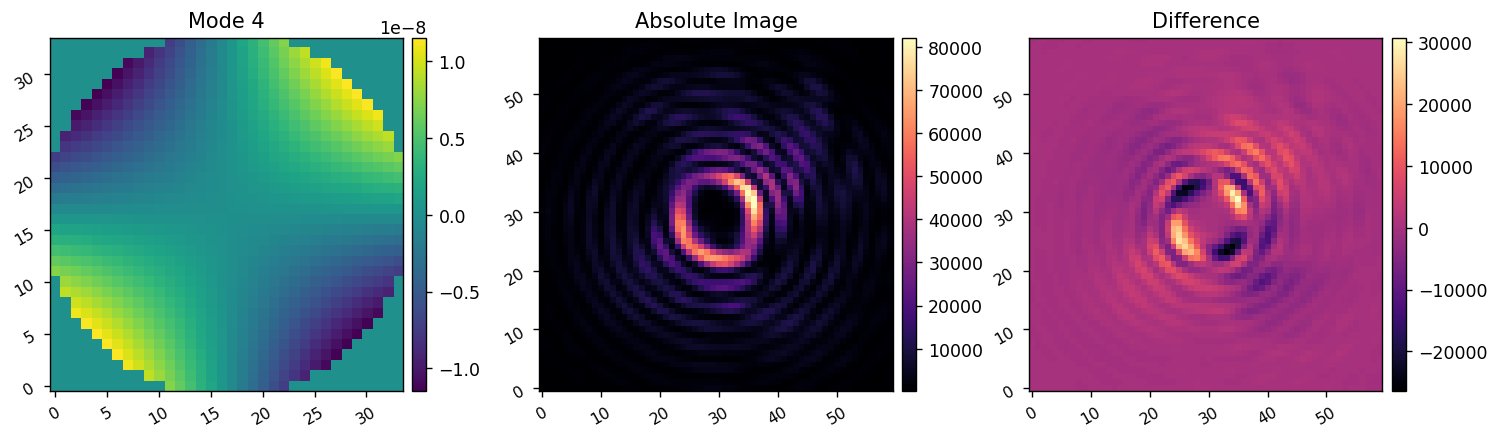

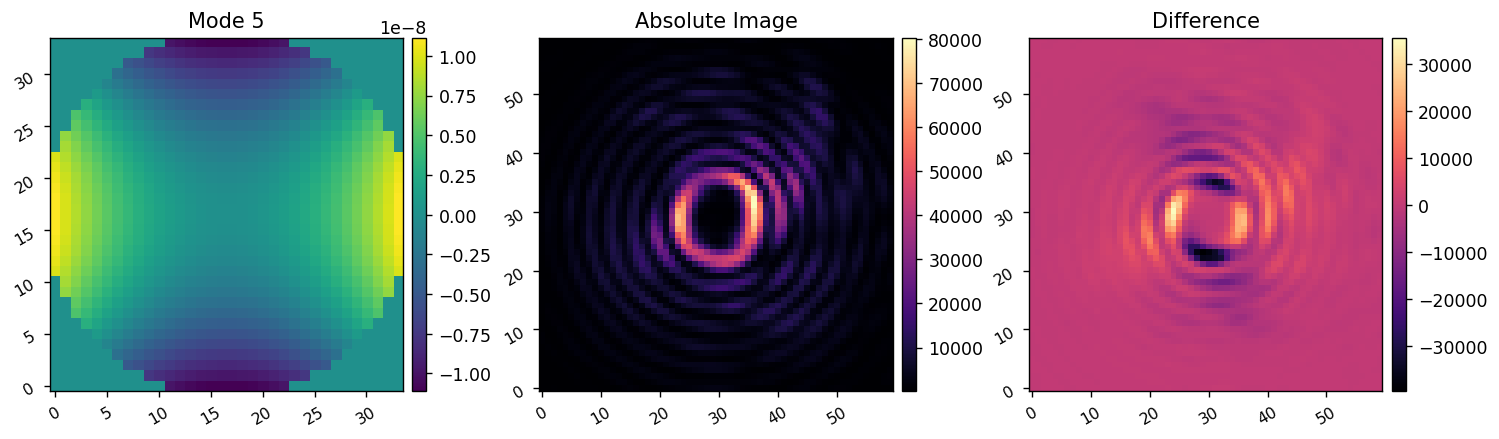

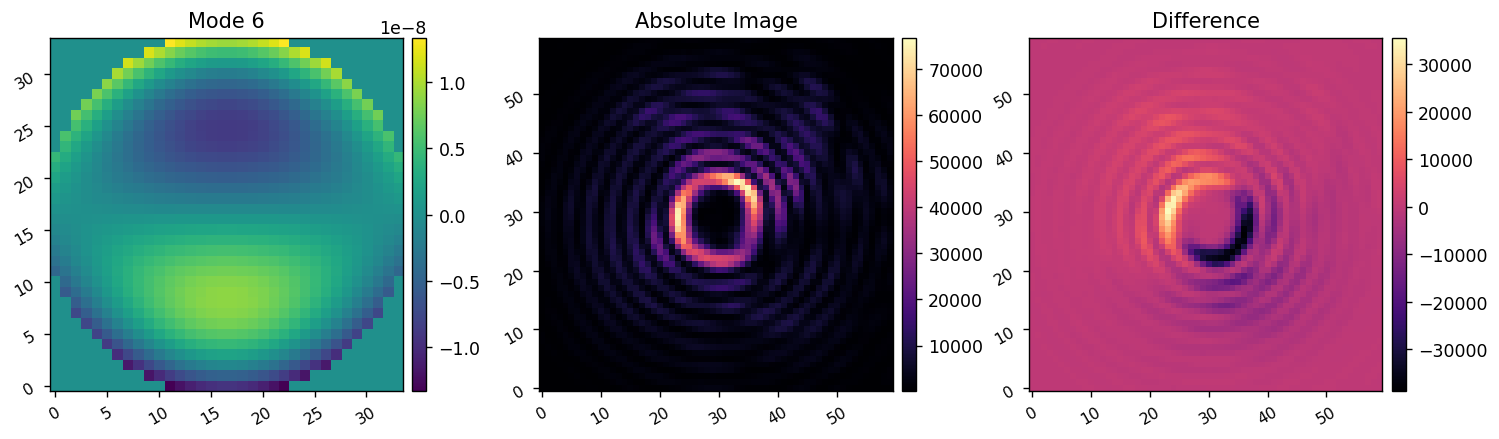

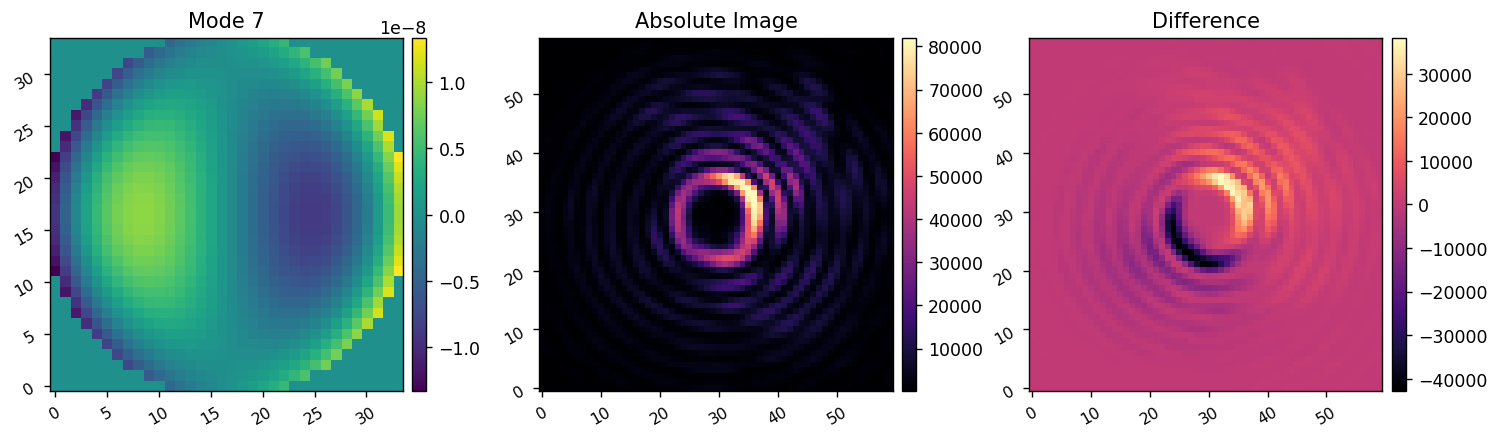

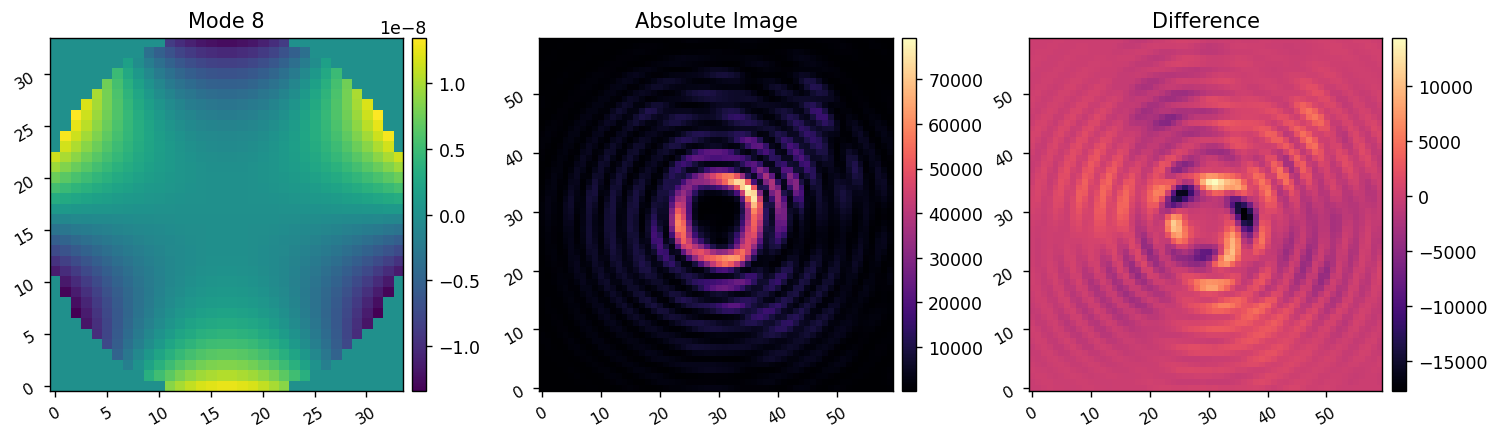

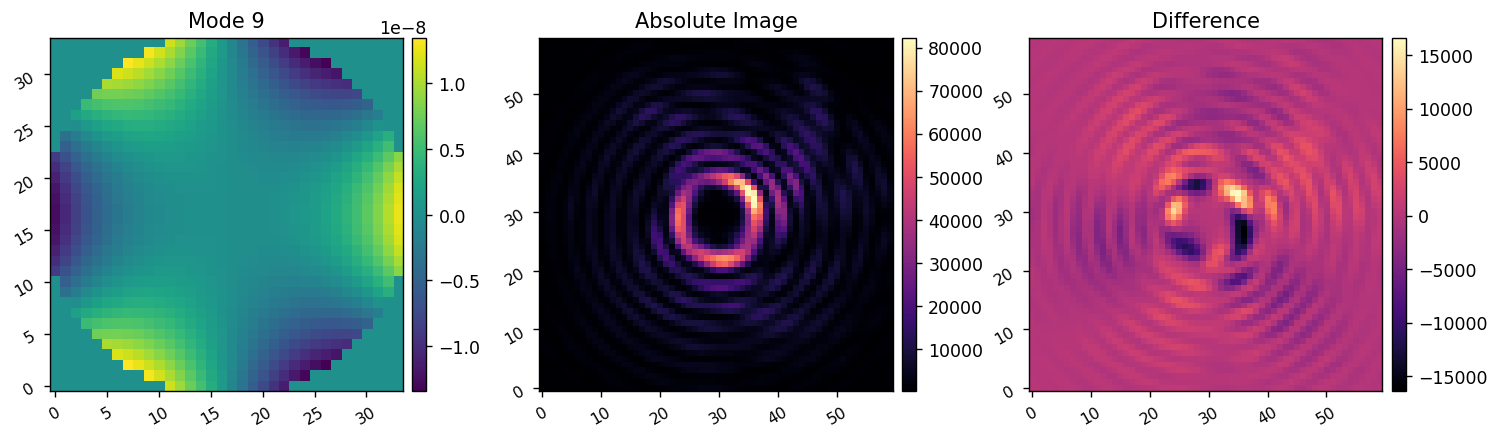

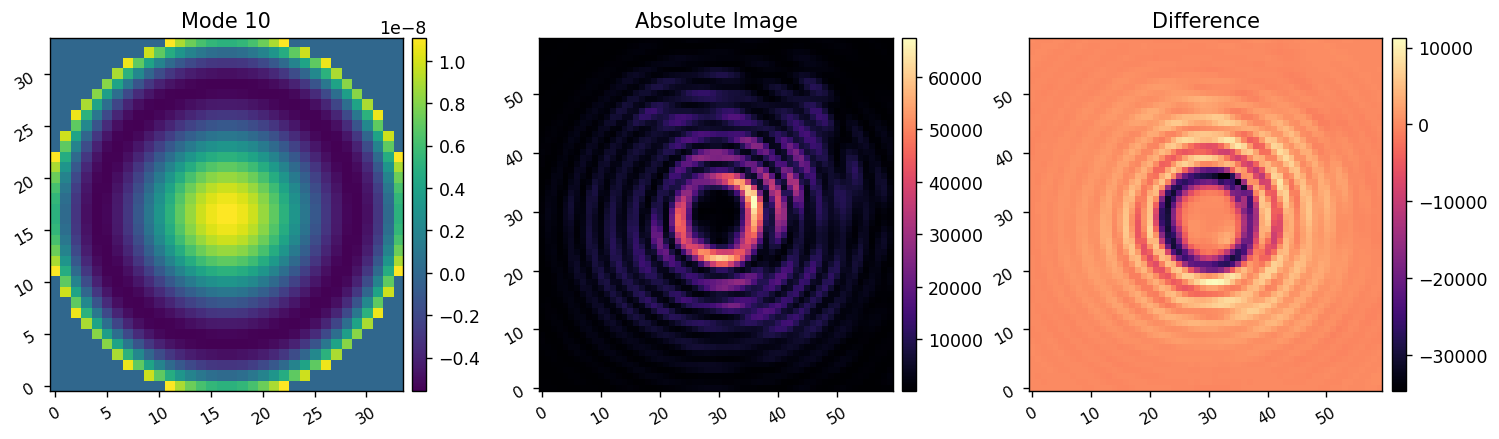

In [92]:
reload(lina.llowfsc)
I.zero_dm()
I.setattr('NLOCAM', 10)
rm = lina.llowfsc.calibrate_without_fsm(I, control_mask, dm_modes=dm_modes, amps=5e-9, plot=True)

In [116]:
cm = ensure_np_array(lina.utils.TikhonovInverse(xp.array(rm), 0))

In [121]:
had_modes = ensure_np_array(lina.utils.create_hadamard_modes(xp.array(I.dm_mask)))
had_modal_matrix = had_modes.reshape(had_modes.shape[0], -1)


In [125]:
had_modal_matrix.shape

(1024, 1156)

In [123]:
reload(lina.llowfsc)
I.zero_dm()
I.setattr('NLOCAM', 10)
I.dm_delay = 2*I.texp_locam
had_rm = lina.llowfsc.calibrate_without_fsm(I, control_mask, dm_modes=had_modes, amps=5e-9, plot=False)

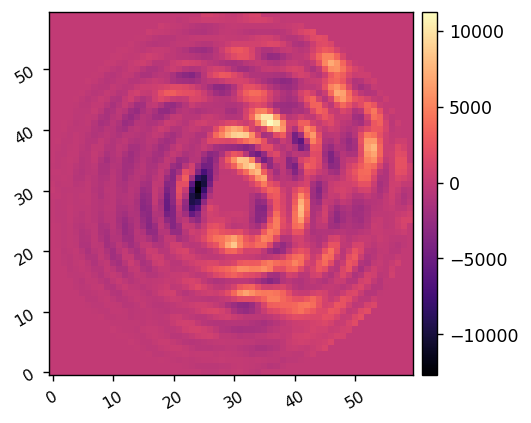

In [127]:
del_ref_im = np.zeros_like(ref_im)
del_ref_im[control_mask] = had_rm.dot(had_modal_matrix.dot(1e-6*dhc_stream.grab_latest().ravel())/1024)
imshow1(del_ref_im)

# Define the function and process to run LLOWFSC at the desired frequency

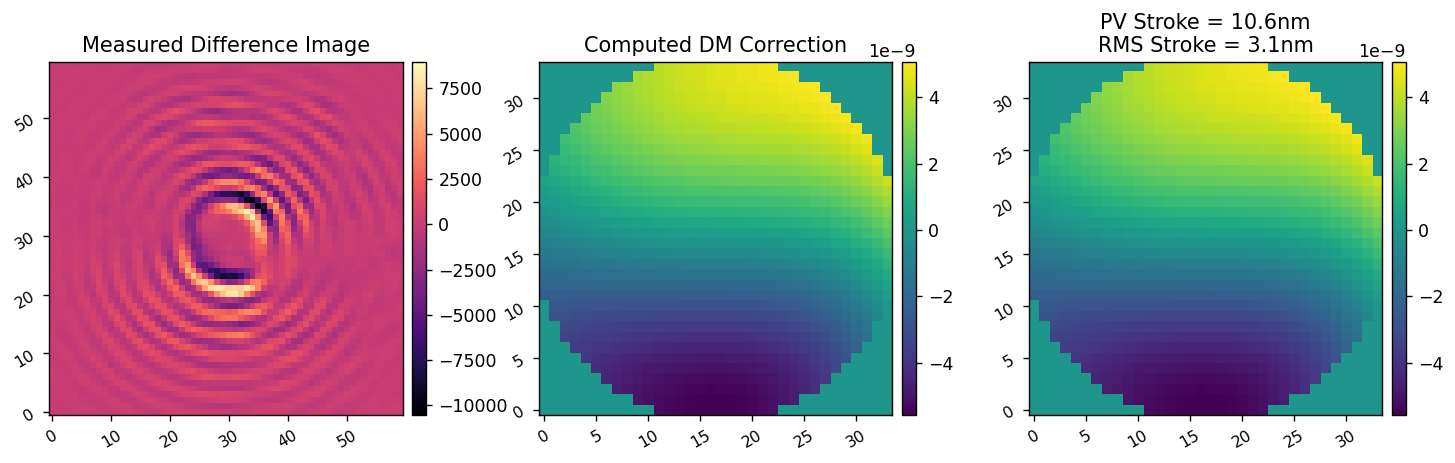

In [117]:
reload(lina.llowfsc)
lina.llowfsc.single_iteration(I, ref_im, cm, zer_modal_matrix, control_mask, thresh=0, plot=True)
I.zero_dm()

In [ ]:
del_ref_im = np.zeros_like(ref_im)
del_ref_im[control_mask] = had_rm.dot(had_modal_matrix.dot(1e-6*dhc_stream.grab_latest()[I.dm_mask])/1024)


In [102]:
reload(scoobi)
reload(lina.llowfsc)
reload(lina.utils)

I.setattr('NLOCAM', 1)
llowfsc_freq = 10
I.return_ni_locam = True
I.dm_delay = 1*I.texp_locam

args = [I, ref_im, cm, modal_matrix, control_mask]
kwargs = {
    'gain':2*[0.5] + 8*[0.05],
    # 'thresh':2*[1e-9] + 8*[0.25e-9],
}

llowfsc_process = lina.utils.Process(1/llowfsc_freq, 
                                       lina.llowfsc.single_iteration, 
                                       args, # the args
                                       kwargs, # the kwargs
                                       )



In [103]:
llowfsc_process.start()

In [104]:
llowfsc_process.cancel()
I.zero_dm()

In [27]:
reload(scoobi)
scoobi.start_kilo_mod(client0, delay=0.1)

llowfsc_process.start()

In [29]:
reload(scoobi)
scoobi.stop_kilo_mod(client0, delay=0.1)

llowfsc_process.cancel()
I.zero_dm()

In [170]:
llowfsc_process.cancel()
I.zero_dm()

In [ ]:
scoobi.set_kilo_mod_amp(1, client0)
scoobi.set_kilo_mod_rate(2*fmax.to_value(u.Hz), client0)

In [128]:
I.zero_dm()